<a href="https://colab.research.google.com/github/RDW287/CM3710-Coding-Assessment/blob/main/AI_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/RDW287/CM3710-Coding-Assessment
%cd CM3710-Coding-Assessment/
!git pull

Cloning into 'CM3710-Coding-Assessment'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 134 (delta 4), reused 102 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 4.67 MiB | 19.27 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/CM3710-Coding-Assessment
Already up to date.


In [23]:
# Required imports for code
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from PIL import Image
from tensorflow import keras, random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

#**Introduction**

The aim of this notebook is to create and compare to two AI algorithms to classify images from the selected dataset. The dataset is of images captured using Meta glass, these include rooms and objects within RGU that are labelled based off the file name. We will be using solely the objects to reduce runtime.

The models will be trained, tested and compared to find the most suitable algorithm for the task of image classification.

No. Images:  40
Image Size: (360, 360)


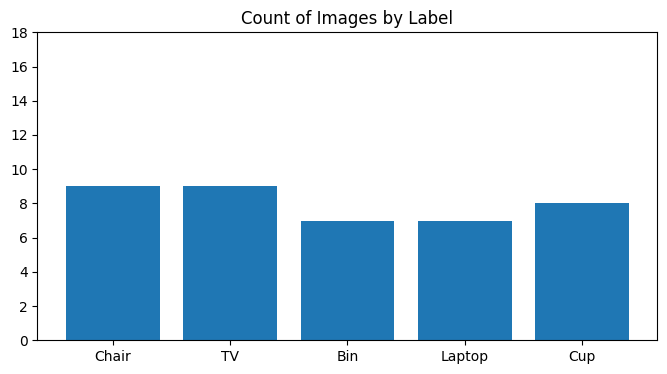

In [3]:
# Data Exploration

directory = "RGU_Images" #The name of the folder containing the images

# Stores the names of the files, this will be used as the labels later
image_filenames = []
files = []
for file in os.listdir(directory):
  name = re.split('_|-', file) #Splits file names by _ and - to get the label as the names are like 1-Bin_1.jpeg
  if name[1] in ("Cup", "TV", "Bin", "Chair", "Laptop"): #We are only looking at the objects rather than the rooms
    image_filenames.append(name[1])
    files.append(file)

# We can see that we have 40 images that are 360x360 pixels in size
print("No. Images: ", len(files))
print("Image Size:", Image.open(f'{directory}/{files[0]}').size)

# Gets the count of each label in the dataset
filename_count = Counter(image_filenames)

# The bar graph below shows that each category has between 7 and 9 images for each, this isnt a large dataset so image augmentation will be required to increase it.
plt.figure(figsize=(8,4))
plt.bar(filename_count.keys(), filename_count.values())
plt.yticks(range(0,20,2))
plt.title("Count of Images by Label")
plt.show()

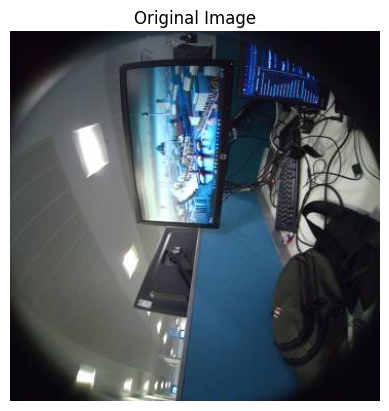

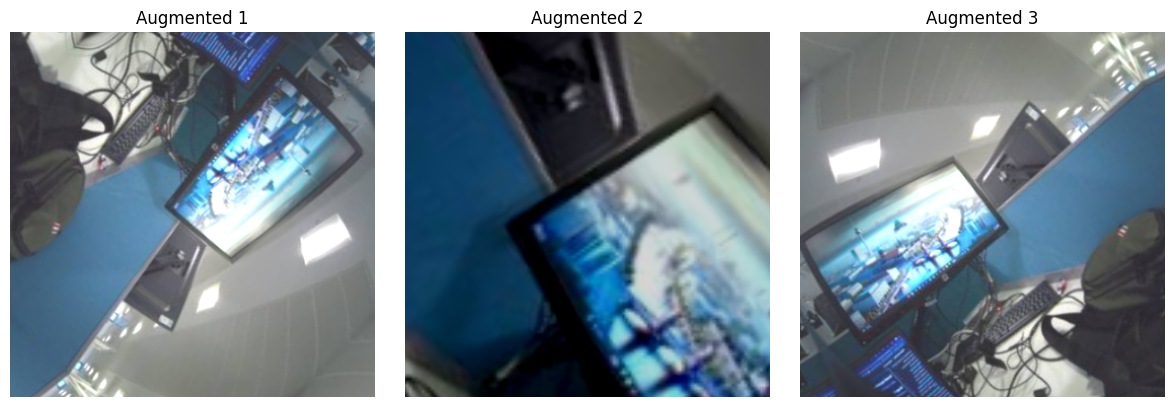

In [4]:
# Data Preprocessing

# We will create a keras layer to apply augmentation techniques to expand our training set, this allows the models to spot trends in images when noise is added
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical", seed=1), #Flips the image horizontally and/or vertically
    keras.layers.RandomRotation(0.5, seed=1), #Adds some rotation to the image
    keras.layers.RandomZoom((-0.75,0), seed=1), #Zooms into a particular point by 0% - 75% allowing it to learn patterns in small areas of the image
    keras.layers.RandomBrightness(factor=0.2, seed=1), #Changes the brightness of the image
    keras.layers.Rescaling(1./255.) #This will scale the image contents to between 0-1, this is min-max normalisation
])

# This is what the original image looks like
img = plt.imread(f'{directory}/{files[1]}')
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# These are examples of how the images will look after augmentation
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    augmented = data_augmentation(img)
    axs[i].imshow(augmented)
    axs[i].set_title(f"Augmented {i + 1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [40]:
# Now we need to create our dataset with the augmented images
images = []
for file in files:
  image = Image.open(f'{directory}/{file}')
  images.append(np.array(image))
images = np.array(images) #We will use a numpy array for compatability with future methods

# We need to convert the labels from the file names into one-hot vectors, it will create an n length array with 0 in every column apart from the one where it matches the label
unique_labels, indices = np.unique(image_filenames, return_inverse=True)
y_categorical = keras.utils.to_categorical(indices)
print("Categorical Vector Example:", y_categorical[0])

# A train test split will be used to leave 40% of the training set as unseen data for testing. This prevents overfitting of the model and allows us to test its suitability on unseen images
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_categorical,
    test_size=0.4, #40% of the entire dataset is set aside, this will not include augmented images as this would cause accuracy overestimation due to small parts of the training data being in the test set
    stratify=y_categorical, #This is a sampling method to help preserve the proportions in our data, it prevents certain low occurring categories not appearing in our test at all
    random_state=1 #Sets a seed so split is the same for everyone who runs this
)

# Now we need to add in our augmented data into our training set, we did this after the split to prevent pieces of training data sneaking into our test set
for x,y in zip(X_train, y_train):
  for j in range(10): #We will create 10 augmented images for each image in our training set, this may take a couple minutes
    augmented = np.array(data_augmentation(x))
    X_train = np.append(X_train, [augmented], axis=0)
    y_train = np.append(y_train, [y], axis=0)

print("New Training Set Size: ", len(X_train))

Categorical Vector Example: [0. 1. 0. 0. 0.]
New Training Set Size:  264


#**Algorithm 1 - Convolutional Neural Network (CNN)**

A CNN is a variation of a neural network, an algorithm based off the human brain, that is often applied to images. It contains Convolution and Max Pooling layers that discover features in the image and summarize, compressing the image while maintaining its features by applying filters across the image.

This is then passed to a dense layer which is a typical neural network containing neurons that take in weights and biases, use an activation function to introduce some non-linearity, and uses backpropogation to train it.

Finally, as it is a classification exercise, it uses softmax to calculate the probability that it falls into each of the classes and picks the one with the biggest chance as the final prediction

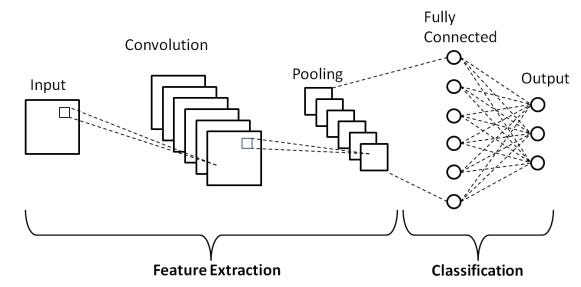

In [41]:
CNN = keras.models.Sequential([
    keras.Input(shape=(360,360,3)), #Specifies that the image is 360x360
    # 1st Convolution block
    keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'), #The convolution layer will have 16 3x3 filters
    keras.layers.MaxPooling2D(pool_size=(2,2)), #The pooling layer will summarise the image in 2x2 sections

    # 2nd Convolution block
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'), #We are going to increase the number of filters to better detect features as the resolution decreases
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 3rd Convolution block
    keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # 4th Convolution block
    keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(), #Turns the image from a nested array into a vector
    keras.layers.Dense(len(y_categorical[0]), activation="softmax"), #The softmax function in the output layer will weight the probability of the image being one of the classes
])

# We will fit the training data to the model, "adam" uses stochastic gradient descent to optimize the network
CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
CNN.fit(X_train, y_train, epochs=10) #10 Epochs means it will run over the full training set 10 times

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.1784 - loss: 6.6103
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2728 - loss: 1.8991
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.3041 - loss: 1.5755
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3193 - loss: 1.4585
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5066 - loss: 1.4163
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4097 - loss: 1.3777
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4726 - loss: 1.3027
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5621 - loss: 1.2021
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5914 - loss: 1.0573
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.7068 - loss: 0.8849


#**Algorithm 2 - Random Forest**

A Random Forest Algorithm is an ensemble method that builds multiple decision trees, it trains each tree on a random set of the data which prevents the overfitting issues likely to occur in a single tree. Each tree will recieve the image and make a vote for the class it predicts it will be, the majority class is outputted for the final decision. Since each tree is different it allows it to find common features through noise.

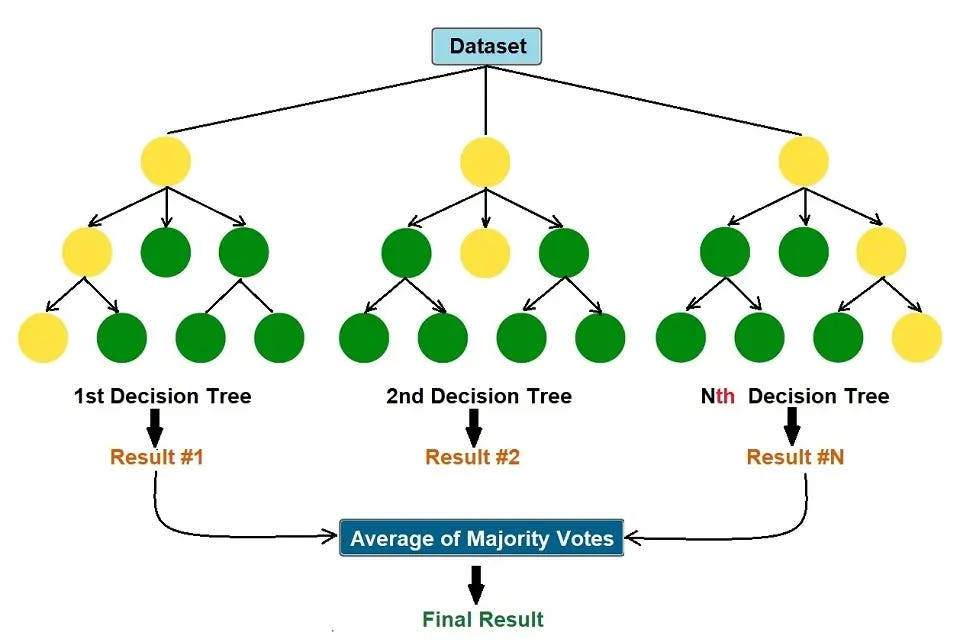


In [42]:
# Algorithm 2 - Random Forest

# As sklearn doesnt accept an array with the same dimensions as tensorflow, we'll neded to flatten them using .reshape()
samples, x, y, rgb = X_train.shape
X_train_reshaped = X_train.reshape((samples,x*y*rgb))

samples, x, y, rgb = X_test.shape
X_test_reshaped = X_test.reshape((samples,x*y*rgb))

# We can tune some hyperparemeters to see which perform best, however we need to make a tradeoff between the number of parameters we try and the time it takes to test them all
param_grid = {
  'bootstrap': [True, False], #Whether to create multiple random samples (with replacement) for training each tree.
  'max_depth': [10, 20, 30], #Sets how many layers deep the tree can go
  'n_estimators': [50, 100, 150] #The total number of trees in the forest
}

# We can now fit the model based off the best performing parameters, by default a 5 fold cross validation is used and it trys 10 different parameter combinations
classifier = RandomForestClassifier()
RFC = RandomizedSearchCV(
    estimator = classifier,
    param_distributions = param_grid,
    random_state = 1,
    verbose = 3
)

RFC.fit(X_train_reshaped, y_train)
print("Best Parameters: ", RFC.best_params_) #This is the parameter combonation with the best result

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.000 total time=   3.8s
[CV 2/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.472 total time=   5.1s
[CV 3/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.189 total time=   3.8s
[CV 4/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.170 total time=   3.9s
[CV 5/5] END bootstrap=True, max_depth=30, n_estimators=50;, score=0.058 total time=   4.8s
[CV 1/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.000 total time=   3.9s
[CV 2/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.472 total time=   3.9s
[CV 3/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.151 total time=   4.4s
[CV 4/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.264 total time=   4.5s
[CV 5/5] END bootstrap=True, max_depth=20, n_estimators=50;, score=0.096 total time=   3.9s
[CV 1/5] END bootst

#**Algorithm Results**

As the below shows, the Convolutional Neural Network has a much higher accuracy (87.5%) than the random forest (56.3%), this means it is classifying the image correctly almost 9 in 10 times. The confusion matrices below also show that for the CNN its the cup images causing the most issues whereas for the RF it seems to classify the images as bins more often, possibly suggesting overfitting.

The F1 score is another metric used to evaluate model performance, it combines precision (of all the images the model predicted as a class, how many were actually that class?) and recall (of all the actual images of the class, how many did the model correctly predict?) into a score between 0-1 with 1 being the best possible, we can see that once again the CNN has a higher F1 (85.3%) than the RF (57.1%)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
CNN Accuracy:  0.875
CNN F1 Score:  0.8526785714285714


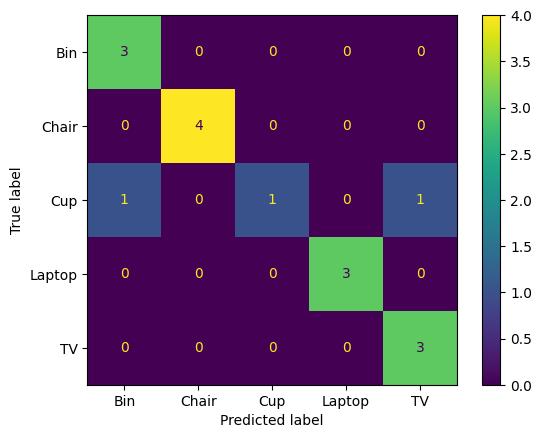


Random Forest Accuracy:  0.5625
Random Forest F1 Score:  0.5705357142857144


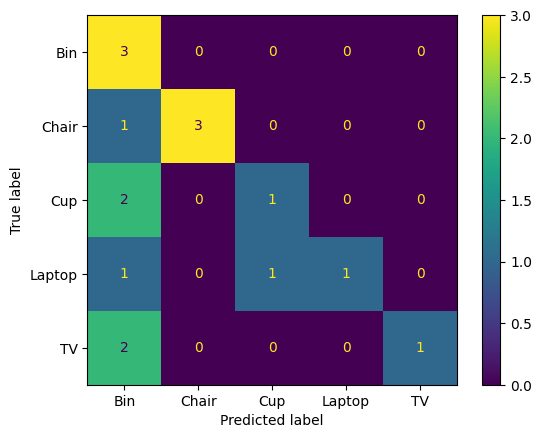

In [67]:
# We can now test the model on some unseen test data to get an idea of the models performence

y_classes = np.argmax(y_test, axis=1)
CNN_pred = np.argmax(CNN.predict(X_test), axis=1)
RFC_pred = np.argmax(RFC.predict(X_test_reshaped), axis=1)

# CNN Results
print("CNN Accuracy: ", accuracy_score(y_classes, CNN_pred))
print("CNN F1 Score: ", f1_score(y_classes, CNN_pred, average="weighted")) #"weighted" calculates the metrics for each label and averages them using the number of class instances as a weight
ConfusionMatrixDisplay(
    confusion_matrix(y_classes, CNN_pred),
    display_labels=unique_labels
).plot()
plt.show()

# Random Forest Results
print("\nRandom Forest Accuracy: ", accuracy_score(y_classes, RFC_pred))
print("Random Forest F1 Score: ", f1_score(y_classes, RFC_pred, average="weighted"))
ConfusionMatrixDisplay(
    confusion_matrix(y_classes, RFC_pred),
    display_labels=unique_labels
).plot()
plt.show()


#**Conclusion**

From these results it appears that the CNN is the better choice, possibly down to the feature extraction ability found in the Convolution and Max Pooling layers which allow the image to be compressed while maintaining the information. Random Forest on the other hand possibly just doesnt have the ability to extract trends and features from complex images like the ones used.

One way we could possibly improve both algorithms is by using a larger dataset, this would allow for a wider range of features to be noticed by the models and in turn, likely increase its accuracy and F1.